In [191]:
import numpy as np
from scipy.stats import chi2
from scipy.stats import norm
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.special as special
from scipy.stats import norm
from scipy.optimize import minimize
from tqdm.notebook import tqdm
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats
from sklearn.utils import resample

In [112]:
# Функция возвращающая плотность распределения Х^2 для заданных параметров
def Chi2(x):
    return chi2.pdf(x, 9)

In [113]:
 # Функция возвращающая плотность нормального распределения для заданных параметров
def Norm(x):
    return norm.pdf(x, 5.27, 2.505)

In [114]:
# Вспомогательная функция для построения равномерного закона распределения
def UniformP(x):
    return x / 9

In [115]:
# Вспомогательная функция для построения эмпирического закона распределения
def OurP(arr):
    for i in range(1, 10):
        arr[i] += arr[i-1]
    return arr

In [116]:
# Функция, считающая дельту в пункте ф
def DeltaChiA(arr):
    summa = 0
    for i in arr:
        summa += ((1./10 - i)**2)*10
    return 100 * summa

In [117]:
# Функция, считающая дельту в пункте б (Непараметр)
def DeltaChiB(arr_p, arr_count):
    summa = 0
    for i in range(10):
        summa += ((arr_p[i] - arr_count[i]/100)**2)/(arr_p[i])
    return 100 * summa

In [118]:
#Функция, строящая эмпирический график и график равномерного распределения и рассчитывающая отклонение для функции распределения Колмогорова
def KolmogorovA(arr):
    values = np.array([i for i in range(10)])
    F = UniformP(values)
    F_ = OurP(arr / 100)
    plt.axis([0, 9, 0, 1])
    plt.title('F(x)')
    plt.plot(values, F)
    plt.step(values, F_, where='post')
    
    arr_delta1 = np.zeros(10)
    arr_delta2 = np.zeros(10)
    for i in range(10):
        arr_delta1[i] = abs(F[i] - F_[i])
    for i in range(1, 10):
        arr_delta2[i-1] = abs(F[i] - F_[i-1])
    sup1 = max(arr_delta1)
    sup2 = max(arr_delta2)
    sup = max(sup1, sup2)
    print(10 * sup)

In [119]:
# Пункт а, Пирсон
arr = np.array([5, 8, 6, 12, 14, 18, 11, 6, 13, 7])
print(DeltaChiA(arr / 100))

16.400000000000002


In [120]:
# p-value для пунка а), Пирсон
result = integrate.quad(Chi2, 16.4, np.inf)
print(result[0])

0.05898403054441968


1.4333333333333331
p-value = 0.03348


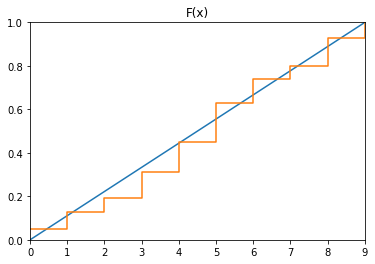

In [121]:
# Пункт а, Колмогоров
arr = np.array([5, 8, 6, 12, 14, 18, 11, 6, 13, 7])
KolmogorovA(arr)
print("p-value = 0.03348")

In [122]:
# Пирсон б
# Численное нахождение параметров нормального закона распределения

intervals = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10)]
counts = [5, 8, 6, 12, 14, 18, 11, 6, 13, 7]

# Преобразование в набор данных
data = []
for (start, end), count in zip(intervals, counts):
    midpoint = (start + end) / 2
    data.extend([midpoint] * count)

#print(data)

# Функция правдоподобия
def likelihood(params):
    mu, sigma = params[0], params[1]
    # Проверка на положительность sigma
    if sigma <= 0:
        return np.inf
    return -np.sum(norm.logpdf(data, mu, sigma))

# Начальные параметры
initial_params = [np.mean(data), np.std(data)]

# Минимизация функции правдоподобия
result = minimize(likelihood, initial_params, method='L-BFGS-B', bounds=[(-np.inf, np.inf), (0, np.inf)])

# Результаты
mu_estimate, sigma_estimate = result.x
print(f'Оценка mu: {mu_estimate}')
print(f'Оценка sigma: {sigma_estimate}')

# Теперь подсчитаем np(i)
integral_intervals = [-np.inf, 1, 2, 3, 4, 5, 6, 7, 8, 9, np.inf]
result1 = [integrate.quad(Norm, integral_intervals[i-1], integral_intervals[i])[0] for i in range(1, 11)]
print(f"Получившиеся вероятности: {result1}")

delta = DeltaChiB(result1, counts)
print(f"Найденное отклонение: {delta}")

answer = integrate.quad(Chi2, 10.803, np.inf)[0]
print(f"p-value = {answer}")

Оценка mu: 5.27
Оценка sigma: 2.505414137423193
Получившиеся вероятности: [0.044135382481009455, 0.05174479086592144, 0.08653810267269128, 0.12366403505253826, 0.1510010354716029, 0.15755050961341668, 0.14046356713930722, 0.10700643479172897, 0.06965534833227047, 0.06824079357947382]
Найденное отклонение: 10.803518976168757
p-value = 0.2894544213512897


In [295]:
def emp(sample_data):
    # Нормализуем частоты для получения вероятностей
    counts = np.array([np.count_nonzero(sample_data == i) for i in range(10)])
    probabilities = counts / counts.sum()
    return np.cumsum(probabilities)

In [296]:
def norm_boots(x, mu, sigma):
    return [norm.cdf(x[i], mu, sigma) for i in range(10)]

In [297]:
def sup(data_emp, data_norm):
    N_ = 10
    arr_delta1 = np.zeros(N_)
    arr_delta2 = np.zeros(N_)
    #print(len(data_emp))
    for i in range(N_):
        arr_delta1[i] = abs(data_norm[i] - data_emp[i])
    for i in range(1, N_):
        arr_delta2[i-1] = abs(data_norm[i] - data_emp[i-1])
    sup1 = max(arr_delta1)
    sup2 = max(arr_delta2)
    sup = max(sup1, sup2)
    #print(sup)
    return sup

In [305]:
def bootstrap(data, data_norm, main_delta, mu, sigma, n_bootstrap_samples = 500):
    bootstrap_arr = []
    N_ = len(data)
    for _ in range(n_bootstrap_samples):
        # Генерация бутстраповской выборки
        sample = resample(data, replace = True)
        data_emp = emp(sample)
        maximum = 10*sup(data_emp, data_norm)
        #print(f"maximum = {maximum}")
        bootstrap_arr.append(maximum)
    
    lenght = len([x for x in bootstrap_arr if x <= main_delta])
    return lenght / n_bootstrap_samples

In [309]:
# Наша выборка
data = np.array(([0] * 5 + [1] * 8 + [2] * 6 + [3] * 12 + [4] * 14 + [5] * 18 + [6] * 11 + [7] * 6 + [8] * 13 + [9] * 7))
values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Получаем оценки параметров по изначальным выборкам
teta1 = np.mean(data)
summa = 0
for i in data:
    summa += (i - teta1)**2
summa /= (len(data) - 1)

teta2 = summa ** 0.5


N = len(data)
emp_data = emp(data)
data_norm = norm_boots(values, teta1, teta2)
delta = 10*sup(emp_data, data_norm)

answer = bootstrap(data, data_norm, delta, teta1, teta2)
print(delta)

1.0020942299329128


In [308]:
selection = np.array([5, 8, 6, 12, 14, 18, 11, 6, 13, 7])

def find_parameter_mean(x):
  return np.mean(x)

def find_parameter_variance(slection_1):
  return np.sqrt(np.var(slection_1) * 100 / 99)

def count_delta(selection, teta1, teta2):
  mx = 0
  incr_selection = [0] * 10
  incr_selection[0] = 0
  for i in range(1, len(selection)):
    incr_selection[i] = selection[i - 1] + incr_selection[i - 1]
  for i in range(len(incr_selection) - 1):
    integral = stats.norm(teta1, teta2).cdf(i)
    if i != 9:
      if mx < max(abs(integral - incr_selection[i] / 100), abs(integral - incr_selection[i + 1] / 100)):
        mx = max(abs (integral - incr_selection[i] / 100), abs(integral - incr_selection[i + 1] / 100))
    else:
      if mx < abs(integral - incr_selection[i] / 100):
        mx = abs(integral - incr_selection[i] / 100)
    return 10 * mx

def bootstrap_par(teta1_waved, teta2_waved, n_bootstrap_samples=50000):
  bootstrap_deltas = []
  for i in range(n_bootstrap_samples):
    samples = np.random.normal(teta1_waved, teta2_waved, 100).astype(int)
    selection_intervals = [0] * 10
    for k in samples:
      if k < 0:
        k = 0
      elif k > 9:
        k = 9
      selection_intervals[k] += 1
    print(selection_intervals)
    bootstrap_deltas.append(count_delta(selection_intervals, find_parameter_mean(samples), find_parameter_variance(samples)))
    print(i, end = " ")
  return bootstrap_deltas


sel = []
for i in range(len(selection)):
  for j in range(selection[i]):
    sel.append(i)
teta1 = find_parameter_mean(sel)
teta2 = find_parameter_variance(sel)
delta = count_delta(selection, teta1, teta2)
print(selection)
print(delta, "- дельта для исходной выборки")
deltas = bootstrap_par(teta1, teta2)
deltas.sort()
s = 0
for i in range(50000):
  if delta > deltas[i]:
    s += 1
  else:
    break
print()

print(s / 50000, end = " ")
if s / 50000 <= 0.05:
  print("Отбрасываем")
elif s / 50000 > 0.05:
  print("Не имеем оснований отбросить")

[ 5  8  6 12 14 18 11  6 13  7]
0.29090374767749816 - дельта для исходной выборки
[5, 11, 11, 17, 15, 12, 10, 13, 1, 5]
0 [9, 5, 12, 15, 17, 19, 14, 5, 3, 1]
1 [9, 4, 10, 18, 19, 12, 11, 10, 2, 5]
2 [11, 8, 3, 15, 12, 13, 17, 9, 6, 6]
3 [9, 3, 10, 13, 11, 17, 18, 7, 4, 8]
4 [5, 8, 9, 18, 14, 18, 15, 8, 2, 3]
5 [7, 7, 13, 19, 16, 13, 13, 6, 2, 4]
6 [7, 9, 5, 15, 11, 19, 9, 12, 6, 7]
7 [3, 9, 15, 19, 11, 14, 12, 7, 4, 6]
8 [7, 7, 12, 18, 15, 12, 15, 6, 7, 1]
9 [6, 8, 11, 14, 18, 14, 13, 4, 6, 6]
10 [6, 9, 13, 15, 12, 16, 12, 7, 7, 3]
11 [1, 9, 4, 16, 14, 22, 13, 12, 4, 5]
12 [9, 7, 11, 9, 13, 15, 17, 6, 5, 8]
13 [9, 4, 13, 10, 18, 15, 12, 5, 7, 7]
14 [5, 10, 11, 10, 18, 11, 13, 8, 9, 5]
15 [8, 9, 8, 14, 13, 19, 15, 5, 5, 4]
16 [5, 8, 10, 17, 19, 17, 15, 3, 3, 3]
17 [7, 6, 7, 11, 23, 14, 13, 9, 6, 4]
18 [12, 6, 10, 15, 14, 14, 11, 6, 5, 7]
19 [4, 8, 6, 16, 19, 10, 16, 11, 6, 4]
20 [6, 8, 15, 14, 13, 17, 12, 5, 8, 2]
21 [11, 7, 10, 11, 14, 13, 7, 14, 6, 7]
22 [4, 8, 8, 16, 22, 17, 6, 10, 4